In [1]:
import numpy as np
import preliz as pz

import gEconpy as ge
import gEconpy.plotting as gp

seed = sum(map(ord, "Intro to gEconpy"))
rng = np.random.default_rng(seed)

# Introduction to gEconpy

gEconpy is a python package for the definition, estimation, and analysis of Dynamic Stochastic General Equlibrium (DSGE) models.

A model begins with a GCN file. This file format was originally introduced by the R package [gEcon](https://gecon.r-forge.r-project.org/), written by Karol Podemski and Kaja Retkiewicz-Wijtiwiak. gEconpy has absolutely no affiliation with their project. Note that while GCN files as originally implemented in gEcon are fully compatible with gEconpy, gEconpy also includes many new features that are *not* backwards compatible. 

To show the different features of gEconpy, we will use a simple RBC model. The model is loaded in using the `ge.model_from_gcn` fucntion.

In [2]:
file_path = ge.data.get_example_gcn("RBC_backward_compat")
model = ge.model_from_gcn(file_path, verbose=True)

Model Building Complete.
Found:
	9 equations
	9 variables
		The following variables were eliminated at user request:
			TC_t, U_t
		The following "variables" were defined as constants and have been substituted away:
			mc_t
	1 stochastic shock
		 0 / 1 has a defined prior.
	6 parameters
		 0 / 6 parameters has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.



## Model Equations

All the FoC are saved in the model object and can be manipulated using Sympy if needed

In [3]:
for eq in model.equations:
    display(eq)

-C_t - I_t + K_t-1*r_t + L_t*w_t

I_t - K_t + K_t-1*(1 - delta)

-lambda_t + C_t**(-sigma_C)

-L_t**sigma_L + lambda_t*w_t

beta*(lambda_t+1*r_t+1 - lambda_t+1*(delta - 1)) - lambda_t

A_t*K_t-1**alpha*L_t**(1 - alpha) - Y_t

alpha*A_t*K_t-1**(alpha - 1)*L_t**(1 - alpha) - r_t

A_t*K_t-1**alpha*(1 - alpha)/L_t**alpha - w_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

## Calibrating Relationships

In [4]:
for eq in model.calibrated_params:
    display(eq)

## Model Summary

To view a summary of the model and the structure of the GCN file that generated it, you can use `ge.print_gcn_file`. This will let you see the exact blocks defined in the GCN, along with the equations. This is *not* the final form of the model -- first order conditions have not been computed, nor have reductions or simpifications been applied. 

In [5]:
ge.print_gcn_file(file_path)

# Solve Steady State

By default, the steady state is found using a combination of Sympy simplifications and scipy optimizers. It can be slow the first time it is run, but it builds a function which can be reused to re-solve the steady-state much more quickly. This is useful when sampling from the prior or posterior.

In [6]:
ss_res = model.steady_state(how="root")

Output()

Steady state found
--------------------------------------------------------------------------------
Optimizer message             The solution converged.
Sum of squared residuals      6.694484089816733e-23
Maximum absoluate error       4.7557513482843206e-12
Gradient L2-norm at solution  3.2121643709890664e-10
Max abs gradient at solution  3.168481449433713e-10


In [7]:
ge.print_steady_state(ss_res)

A_ss               1.000
C_ss               2.358
I_ss               0.715
K_ss              35.732
L_ss               0.820
Y_ss               3.073
lambda_ss          0.276
r_ss               0.030
w_ss               2.436


## Steady State Equations

If you want to work with the steady state equations, use `ge.utilities.eq_to_ss`. This sends all variables in an equation to the steady state.

In [8]:
for eq in model.equations:
    display(ge.utilities.eq_to_ss(eq).simplify())

-C_ss - I_ss + K_ss*r_ss + L_ss*w_ss

-delta*K_ss + I_ss

-lambda_ss + C_ss**(-sigma_C)

-L_ss**sigma_L + lambda_ss*w_ss

lambda_ss*(beta*(-delta + r_ss + 1) - 1)

A_ss*K_ss**alpha*L_ss**(1 - alpha) - Y_ss

alpha*A_ss*K_ss**(alpha - 1)*L_ss**(1 - alpha) - r_ss

(-A_ss*K_ss**alpha*(alpha - 1) - L_ss**alpha*w_ss)/L_ss**alpha

rho_A*log(A_ss) + epsilon_A_ss - log(A_ss)

To get the variables themselves, you can use `x.to_ss()`. For example:

In [9]:
ss_vars = [x.to_ss() for x in model.variables]
ss_vars

[A_ss, C_ss, I_ss, K_ss, L_ss, Y_ss, lambda_ss, r_ss, w_ss]

In [10]:
ss_vars[0]

A_ss

# Linearization

The first step in solving a DSGE model is to linearize the non-linear system. The `model.linearize_model` takes symbolic derivatives of your model equations with respect to variables at time $t-1$ (`A` matrix), $t$ (`B` matrix), $t+1$ (`C` matrix), and shocks (`D` matrix), and evaluates the resulting derivatives at the steady state.

In [11]:
A, B, C, D = model.linearize_model(steady_state_kwargs={"how": "root"})

Output()

Steady state found
--------------------------------------------------------------------------------
Optimizer message             The solution converged.
Sum of squared residuals      6.694484089816733e-23
Maximum absoluate error       4.7557513482843206e-12
Gradient L2-norm at solution  3.2121643709890664e-10
Max abs gradient at solution  3.168481449433713e-10


Matrices are returned as numpy arrays

In [12]:
with np.printoptions(linewidth=1000, precision=3, suppress=True):
    print(A)

[[ 0.     0.     0.     1.076  0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.    35.018  0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     1.076  0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.    -0.02   0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.853  0.     0.     0.     0.     0.   ]
 [ 0.95   0.     0.     0.     0.     0.     0.     0.     0.   ]]


This is pretty ugly though. You can convert a matrix to a pandas dataframe using `ge.matrix_to_dataframe`. It will try to guess what the labels should be, but in this case the default guess is wrong. We have to tell it that dim1 (the index) are the model equations, not the variables.

In [13]:
ge.matrix_to_dataframe(A, model, dim1="equation", round=3)

,A,C,I,K,L,Y,lambda,r,w
Equation 0,0.00,0.0,0.0,1.076,0.0,0.0,0.0,0.0,0.0
Equation 1,0.00,0.0,0.0,35.018,0.0,0.0,0.0,0.0,0.0
Equation 2,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
Equation 3,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
Equation 4,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
Equation 5,0.00,0.0,0.0,1.076,0.0,0.0,0.0,0.0,0.0
Equation 6,0.00,0.0,0.0,-0.020,0.0,0.0,0.0,0.0,0.0
Equation 7,0.00,0.0,0.0,0.853,0.0,0.0,0.0,0.0,0.0
Equation 8,0.95,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0


By default, the parameter values set in the GCN file will be used. You are always allowed to set new values, though. For example, we can change $\rho$ from 0.95 to 0.5:

In [14]:
A, B, C, D = model.linearize_model(rho_A=0.5, steady_state_kwargs={"how": "root"})

Output()

Steady state found
--------------------------------------------------------------------------------
Optimizer message             The solution converged.
Sum of squared residuals      2.003448624648822e-31
Maximum absoluate error       4.440892098500626e-16
Gradient L2-norm at solution  3.1831662302249865e-14
Max abs gradient at solution  3.172462292866385e-14


Notice that the value of $A$ at `Equation 8` is now 0.5

In [15]:
ge.matrix_to_dataframe(A, model, dim1="equation", round=3)

,A,C,I,K,L,Y,lambda,r,w
Equation 0,0.0,0.0,0.0,1.076,0.0,0.0,0.0,0.0,0.0
Equation 1,0.0,0.0,0.0,35.018,0.0,0.0,0.0,0.0,0.0
Equation 2,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
Equation 3,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
Equation 4,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
Equation 5,0.0,0.0,0.0,1.076,0.0,0.0,0.0,0.0,0.0
Equation 6,0.0,0.0,0.0,-0.020,0.0,0.0,0.0,0.0,0.0
Equation 7,0.0,0.0,0.0,0.853,0.0,0.0,0.0,0.0,0.0
Equation 8,0.5,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0


Computing the steady state might be expensive if your model is much larger. If you've already computed the steady state, you can give it to `linearize_model`. This skip re-solving the steady state.

:::{warning} Be careful providing a steady state!
    
If you pass new parameter values together with a pre-computed steady state, **you** must ensure that they agree! If you compute the steady state using one set of parameters, then linearize with another set of parameters, the solution will not be correct. No checking is done to ensure consistency!
:::

In [16]:
A, B, C, D = model.linearize_model(steady_state=ss_res)

Here's an example of an inconsistent steady state and linearization. If I change $\beta$ from the default (0.99) to  a new value value, gEconpy will:

1. Compute symbolic derivatives of the system of equations (no values are involved at this point)
2. Cast all variables to the steady state
3. Plug in the steady state values you provided! This will be consistent with $\beta = 0.99$
4. Plug in the parameter values you requested. This will be consistent with $\beta = 0.9$

As you can see, no errors or warnings are raised, but this linearized matrix is *wrong*!

In [17]:
A_wrong, B_wrong, C_wrong, D_wrong = model.linearize_model(steady_state=ss_res, beta=0.9)

Here are is the difference between the right and wrong matrices. Since we messed up $\beta$, the relevant matrix is C -- derivatives with respect to the variables at time $t+1$.

In [18]:
ge.matrix_to_dataframe(C - C_wrong, model, dim1="equation").style.format(precision=3).background_gradient(cmap="YlGn")

,A,C,I,K,L,Y,lambda,r,w
Equation 0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Equation 1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Equation 2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Equation 3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Equation 4,0.000,0.000,0.000,0.000,0.000,0.000,0.025,0.001,0.000
Equation 5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Equation 6,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Equation 7,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Equation 8,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


# Perturbation Solution

Like the steady state solution, the perturbation solution constructs a function to solve linearized system via perturbation. 

Following Dynare, the default pertubation solver is Cycle Reduction, implemented in Numba for faster execution. You can also ask for Gensys if you wish. The original gEcon used Gensys.

Like `linearize_model`, you can provide a steady state result to `solve_model`. You can also ask for parameter updates by passing parameter names as keyword arguments. The same warnings about consistency between the provided steady state and parameter updates apply here!

In [19]:
T, R = model.solve_model(steady_state=ss_res)

Solution found, sum of squared residuals: 0.000000000
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


Also like `linearize_model`, if you don't pass `steady_state`, it will automatically re-compute it. 

In [20]:
T_gensys, R_gensys = model.solve_model(solver="gensys", steady_state_kwargs={"how": "root"})

Output()

Steady state found
--------------------------------------------------------------------------------
Optimizer message             The solution converged.
Sum of squared residuals      6.694484089816733e-23
Maximum absoluate error       4.7557513482843206e-12
Gradient L2-norm at solution  3.2121643709890664e-10
Max abs gradient at solution  3.168481449433713e-10
Gensys return codes: 1 1 0, with the following meaning:
Gensys found a unique solution.
Policy matrices have been stored in attributes model.P, model.Q, model.R, and model.S
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


Both gensys and cycle_reduction should give the same answer

In [21]:
np.allclose(T, T_gensys), np.allclose(R, R_gensys)

(True, True)

Like `linearize_model`, `solve_model` will return numpy arrays. You can change them to a pandas dataframe using `ge.matrix_to_dataframe`. In this case, the guess about the rows and columns is correct.

Note that only two columns have non-zero entries. This is because $A$ and $K$ are the state variables. All of the zeros are associated with jumper variables.

In [22]:
ge.matrix_to_dataframe(T, model).style.format(precision=2).background_gradient(cmap="YlGn")

,A,C,I,K,L,Y,lambda,r,w
A,0.95,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00
C,0.31,0.00,0.00,0.48,0.00,0.00,0.00,0.00,0.00
I,3.64,-0.00,-0.00,-0.51,-0.00,-0.00,-0.00,-0.00,-0.00
K,0.07,-0.00,-0.00,0.97,-0.00,-0.00,-0.00,-0.00,-0.00
L,0.21,0.00,0.00,-0.16,0.00,0.00,0.00,0.00,0.00
Y,1.08,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00
lambda,-0.46,0.00,0.00,-0.72,0.00,0.00,0.00,0.00,0.00
r,1.08,0.00,0.00,-0.75,0.00,0.00,0.00,0.00,0.00
w,0.88,0.00,0.00,0.40,0.00,0.00,0.00,0.00,0.00


The $R$ matrix maps the shocks to the different states in the economy. In this case, we expect everything is affected by a total factor productivity shock. And since the law of motion of technology is $\ln A_t = \rho_A \ln A_{t-1} + \epsilon_{A,t}$, it's a nice sanity check to see the effect of $\epsilon_A$ on $A_t$ is 1.

In [23]:
ge.matrix_to_dataframe(R, model).style.format(precision=2).background_gradient(cmap="YlGn")

,epsilon_A
A,1.00
C,0.33
I,3.83
K,0.08
L,0.22
Y,1.14
lambda,-0.49
r,1.14
w,0.92


## Blanchard-Kahn Conditions

After you have a perturbation solution, you can check the Eigenvalues of the system to make sure the BK conditions are satisfied.

The output shows the eigenvalues computed by gensys: the modulus, real part, and imaginary part.

In [24]:
ge.check_bk_condition(model, steady_state=ss_res);

Model solution has 2 eigenvalues greater than one in modulus and 2 forward-looking variables. 
Blanchard-Kahn condition is satisfied.


You can also visualize the Eigenvalues using `plot_eigenvalues` in the plotting functions.

Model solution has 2 eigenvalues greater than one in modulus and 2 forward-looking variables. 
Blanchard-Kahn condition is satisfied.


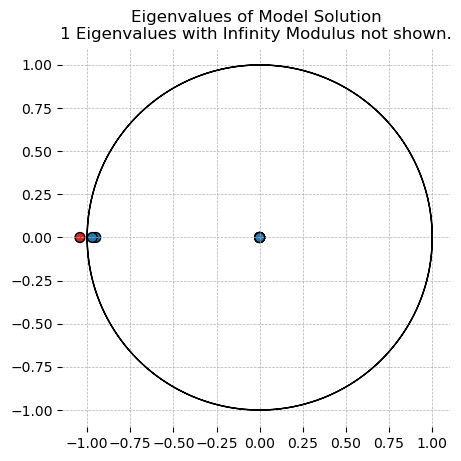

In [25]:
gp.plot_eigenvalues(model, linearize_model_kwargs={"steady_state": ss_res});

## Model Statistics

Functions to compute the stationary covariance matrix, as well as autocovariances for each variable, are also available.

In [26]:
cov = np.eye(1) * 0.1
sigma = ge.stationary_covariance_matrix(model, T=T, R=R, shock_cov_matrix=cov)
acorr = ge.autocovariance_matrix(model, T=T, R=R, shock_cov_matrix=np.eye(1), n_lags=30)

In [27]:
sigma.style.format(precision=2).background_gradient(cmap="YlGn")

,A,C,I,K,L,Y,lambda,r,w
A,1.03,0.79,3.44,1.00,0.07,1.41,-1.18,0.46,1.33
C,0.79,0.97,2.26,1.51,-0.06,1.27,-1.46,-0.22,1.33
I,3.44,2.26,11.98,2.56,0.38,4.52,-3.39,2.15,4.14
K,1.00,1.51,2.56,2.47,-0.17,1.75,-2.26,-0.71,1.92
L,0.07,-0.06,0.38,-0.17,0.04,0.04,0.09,0.22,-0.00
Y,1.41,1.27,4.52,1.75,0.04,2.03,-1.90,0.33,1.99
lambda,-1.18,-1.46,-3.39,-2.26,0.09,-1.90,2.18,0.33,-2.00
r,0.46,-0.22,2.15,-0.71,0.22,0.33,0.33,1.10,0.11
w,1.33,1.33,4.14,1.92,-0.00,1.99,-2.00,0.11,1.99


Unlike the stationary covariance, the computed autocovariances will be returned as an `xarray` with a `lag` dimension. This lets you inspect correlations between all combinations of variables and timesteps.

You can also plot the covaraince matrix as a heatmap using `gp.plot_covariance_heatmap`. This is basically the same as the styled pandas dataframe, but you can pick which one you think is prettier!

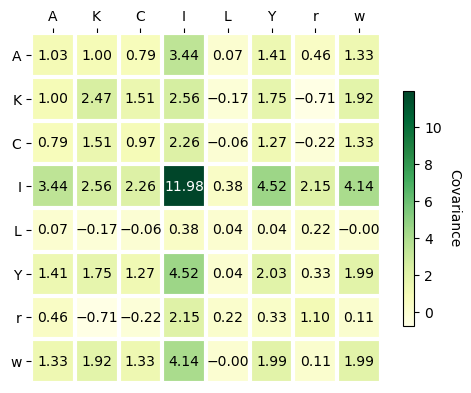

In [28]:
gp.plot_covariance_matrix(
    sigma,
    ["A", "K", "C", "I", "L", "Y", "r", "w"],
    figsize=(5, 5),
    cbar_kw={"shrink": 0.5},
);

Similarly, there is a function to plot the autocorrelation functions, `plot_acf`. This only plots self-autocorrelations. For the off-diagonals, you will need to hand-roll something.

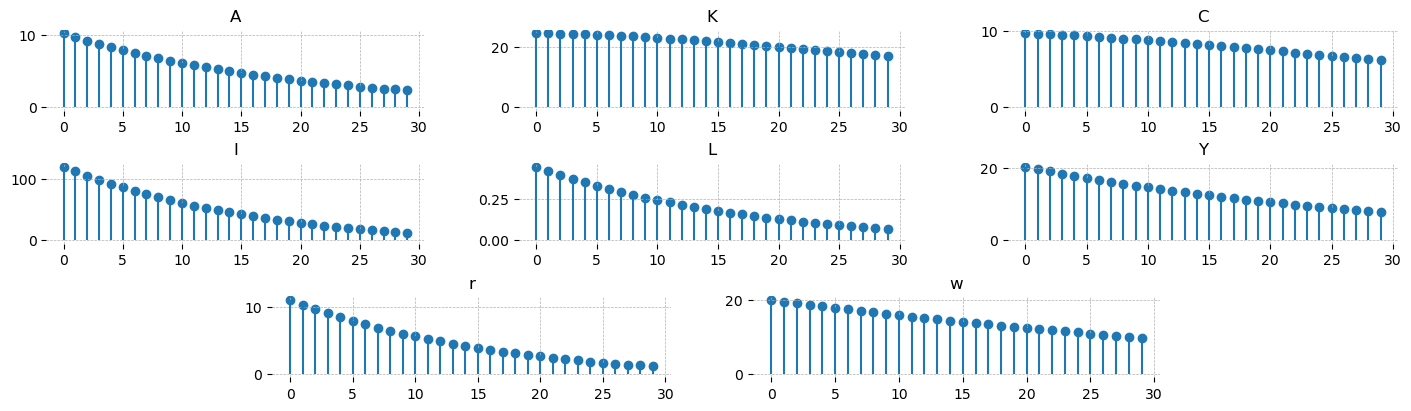

In [29]:
gp.plot_acf(acorr, vars_to_plot=["A", "K", "C", "I", "L", "Y", "r", "w"], n_cols=3);

# Simulation

You can simulate the model by passing a covariance matrix for the shocks. The default is a spaghetti plot, but you can also ask for confidence intervals if you prefer a cleaner look.

In [30]:
simulation = ge.simulate(model, T, R, shock_cov_matrix=cov, n_simulations=100, random_seed=rng)

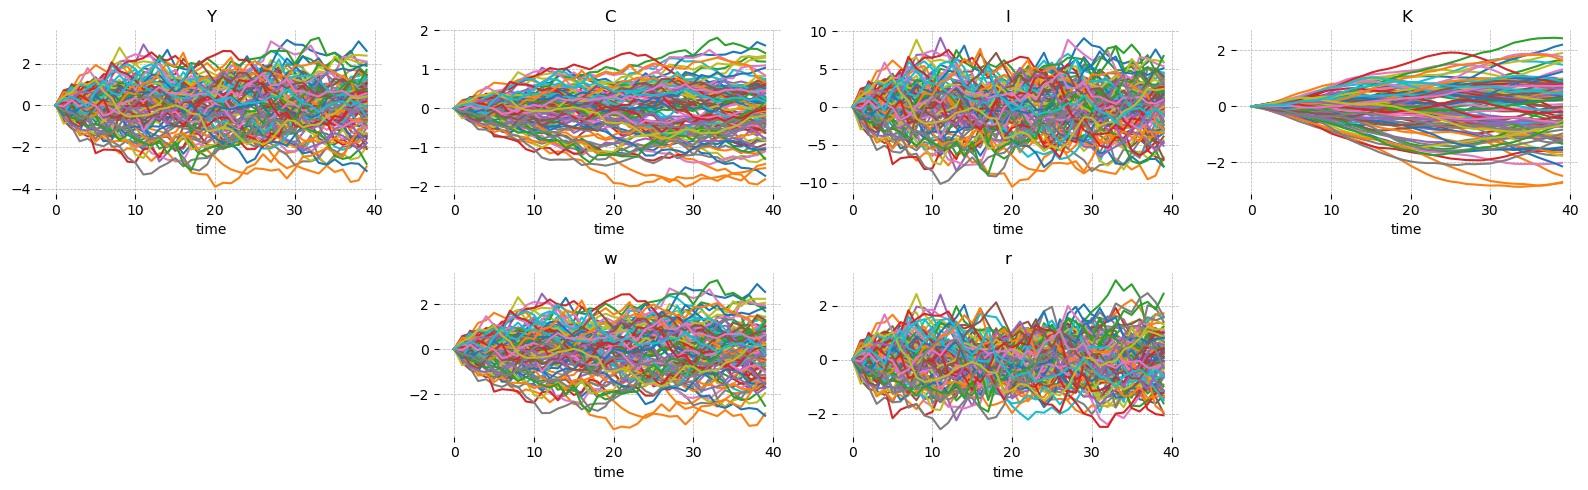

In [31]:
gp.plot_simulation(simulation, vars_to_plot=["Y", "C", "I", "K", "w", "r"], n_cols=4, figsize=(16, 5));

The confidence intervals need plenty of simulations or else they come out looking quite "jagged".

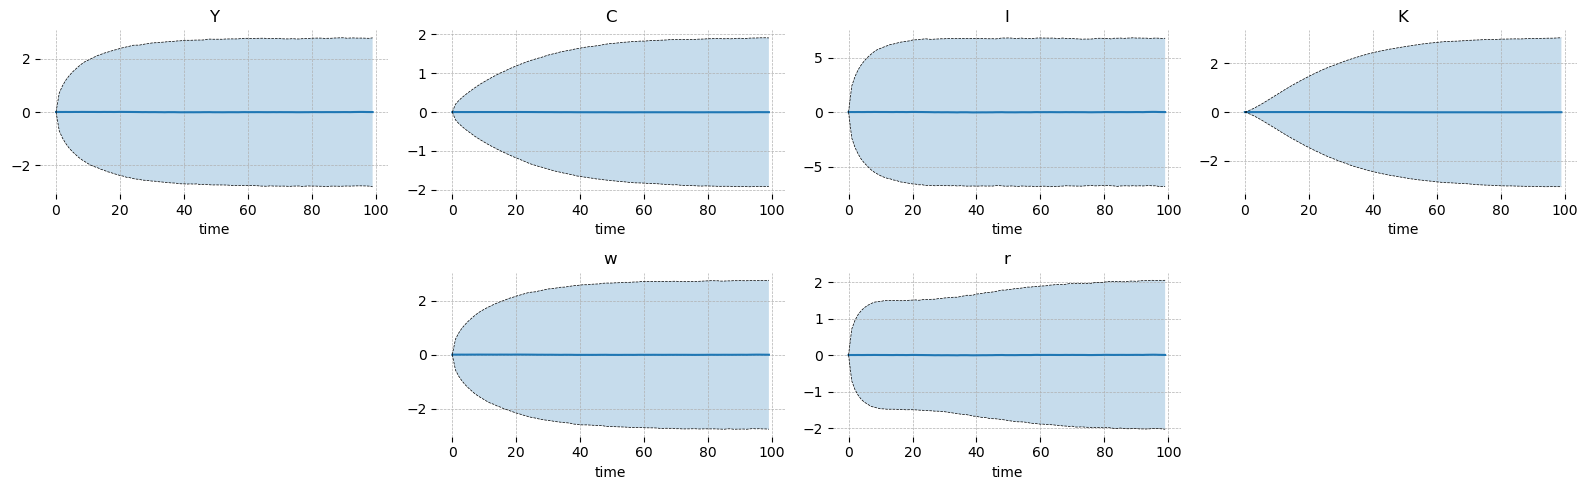

In [32]:
simulation = ge.simulate(
    model,
    T,
    R,
    shock_cov_matrix=cov,
    n_simulations=100_000,
    simulation_length=100,
    random_seed=rng,
)

gp.plot_simulation(
    simulation,
    vars_to_plot=["Y", "C", "I", "K", "w", "r"],
    ci=0.95,
    n_cols=4,
    figsize=(16, 5),
);

With a large number of simulations you can also compute sample statistics and verify the stationary solution. Evidently they match to about the 2nd decimal place with 10_000 samples at T=99. One could extend `simulation_length` and increase `n_simulations` to obtain more accurate estimates.

In [33]:
import pandas as pd

tols = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
accuracy_df = pd.DataFrame(0, columns=tols, index=[x.base_name for x in model.variables])
for tol in tols:
    accuracy_df[tol] = ((np.cov(simulation.isel(time=-1).values.T) - sigma).abs() < tol).all()
print("Absolute difference between stationary covariance matrix and sample covariance matrix is less than:")
print(accuracy_df.to_string())

Absolute difference between stationary covariance matrix and sample covariance matrix is less than:
        0.10000  0.01000  0.00100  0.00010  0.00001
A          True     True    False    False    False
C          True    False    False    False    False
I          True    False    False    False    False
K          True    False    False    False    False
L          True     True    False    False    False
Y          True    False    False    False    False
lambda     True    False    False    False    False
r          True    False    False    False    False
w          True    False    False    False    False


# Impulse Response Functions

They are impulse repsonse functions. Not much to say. The plots start from 0 and the shock enters at 1, which is different from Dynare, which starts the plot at the period the shock enters. The `irf` object returned by the `model.impulse_response_function` method is an `xarray.Dataset` with dimensions `(shock, time, variable)`. 

In [34]:
irf = ge.impulse_response_function(model, T=T, R=R, shock_size={"epsilon_A": 1.0})

In [35]:
type(irf)

xarray.core.dataarray.DataArray

In [36]:
irf.dims

('shock', 'time', 'variable')

To plot the IRFs, use `gEconpy.plotting.plot_irf`. You can request only specific variables using `vars_to_plot`, and `shocks_to_plot` to select specific shocks. There's only one shock in this case, so we don't use `shocks_to_plot`.

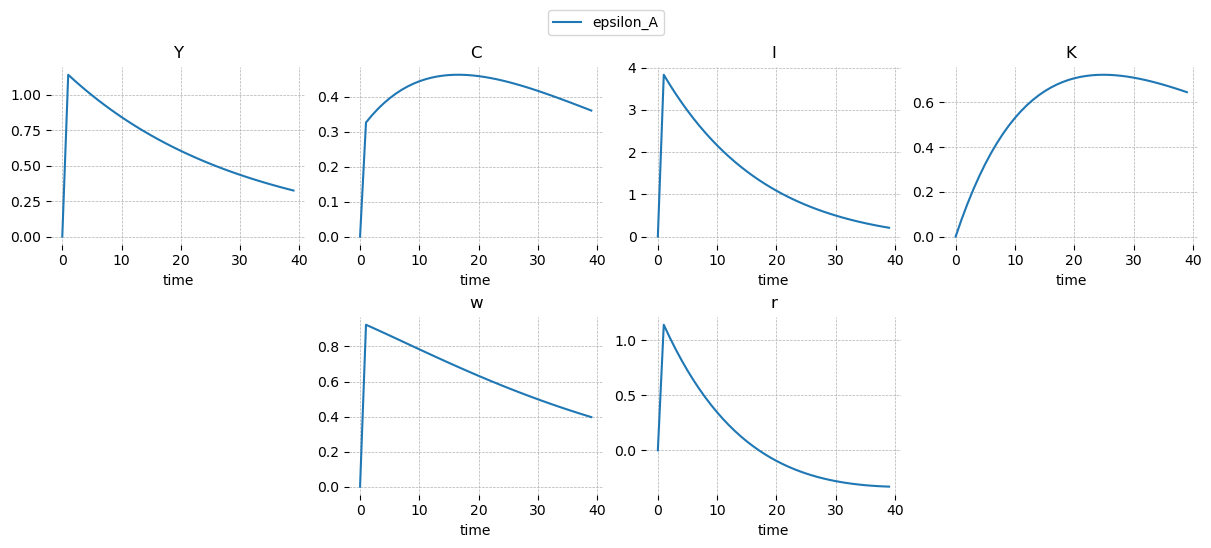

In [37]:
gp.plot_irf(
    irf,
    vars_to_plot=["Y", "C", "I", "K", "w", "r"],
    n_cols=4,
    figsize=(12, 5),
    legend=True,
);

# Covnert to Dynare

Since Dynare remains the gold standard for DSGE model analysis, gEconpy can convert the model into a Dynare `.mod` file. 

Initial values are set to the steady-state we already computed. Of course you're free to modify the generated mod file as you like after you copy it over to MatLab.

In [38]:
print(ge.make_mod_file(model))

var A, C, I, K, L, Y, lambda, r, w;

varexo epsilon_A;

parameters alpha, beta, delta, rho_A, sigma_C, sigma_L;

alpha = 0.350;
beta = 0.990;
delta = 0.020;
rho_A = 0.950;
sigma_C = 1.500;
sigma_L = 2.000;


model;

-C - I + K(-1) * r + L * w;
I - K + K(-1) * (1 - delta);
-lambda + C ^ (-sigma_C);
-L ^ sigma_L + lambda * w;
beta * (lambda(+1) * r(+1) - lambda(+1) * (delta - 1)) - lambda;
A * K(-1) ^ alpha * L ^ (1 - alpha) - Y;
alpha * A * K(-1) ^ (alpha - 1) * L ^ (1 - alpha) - r;
A * K(-1) ^ alpha * L ^ (-alpha) * (1 - alpha) - w;
rho_A * log(A(-1)) + epsilon_A - log(A);

end;

initval;
A = 1.000;
C = 2.358;
I = 0.715;
K = 35.732;
L = 0.820;
Y = 3.073;
lambda = 0.276;
r = 0.030;
w = 2.436;

end;

steady;
resid;

check(qz_zero_threshold=1e-20);

shocks;
var epsilon_A;
stderr 0.01;

end;

stoch_simul(order=1, irf=100, qz_zero_threshold=1e-20);


# Adding a steady state block

`RBC_backward_compat.gcn` shows the "basic" features of gEconpy using a file that is completely backwards compatible with the R package gEcon. There are many more features you can and should take advantage of!

The first one is that you can provide an analytical steady state in your GCN file via a `steady_state` block. You're even allow to pass a partial steady state. For an example of that, see the {ref}`multiple households case study<case_study/multiple_households>` 

In [39]:
file_path = ge.data.get_example_gcn("RBC")
model = ge.model_from_gcn(file_path, verbose=True)

Model Building Complete.
Found:
	9 equations
	9 variables
		The following variables were eliminated at user request:
			TC_t, U_t
		The following "variables" were defined as constants and have been substituted away:
			mc_t
	1 stochastic shock
		 0 / 1 has a defined prior.
	6 parameters
		 6 / 6 parameters has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.



## Steady-State Equations

In this case, I've entered the entire steady state system in the GCN file. If only a partial system is provided, the provided equations will be used to shrink down the number of variables the optimizer needs to look for. gEconpy can use either root finding or loss minimization algorithms to numerically find the steady state, so provided equations don't need to result in simplification down to a square system!

The most ergonomic way to view the provided equations is to look at the output of `print_gcn_file`. Notice that there is now a `steady_state` block. Expand it to see the steady state equations as they were entered in the GCN.

In [40]:
ge.print_gcn_file(file_path)

## Solve Steady State

Since the entire steady state is provided, There is no need to do any numerical optimization. The values are just computed and returned.

In [41]:
ss_res = model.steady_state()
ge.print_steady_state(ss_res)

A_ss               1.000
C_ss               2.358
I_ss               0.715
K_ss              35.732
L_ss               0.820
Y_ss               3.073
lambda_ss          0.276
r_ss               0.030
w_ss               2.436



It is still possible for the anayltic solution to fail of course -- this can happen if you set parameters to bad values (like $\alpha > 1$ or something). You can always check `ss_res.success` to make sure everything worked.

In [42]:
ss_res.success

True

## Perturbation Solution

Linearization and perturbation can be done as normal. The steady state function is now very cheap, so I don't recommend passing the steady state to these functions in this case, but of course you still can. If you don't, you will not have to worry about the "gotcha" from mismatched parameters.

In [43]:
T, R = model.solve_model()

Solution found, sum of squared residuals: 0.000000000
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [44]:
for name, policy_matrix in zip(["T", "R"], [T, R], strict=False):
    print(name.center(10).center(50, "="))
    display(ge.matrix_to_dataframe(policy_matrix, model))

====================    T     ====================


,A,C,I,K,L,Y,lambda,r,w
A,0.950000,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0
C,0.309657,0.0,0.0,0.478747,0.0,0.0,0.0,0.0,0.0
I,3.640697,-0.0,-0.0,-0.512728,-0.0,-0.0,-0.0,-0.0,-0.0
K,0.072814,-0.0,-0.0,0.969745,-0.0,-0.0,-0.0,-0.0,-0.0
L,0.206602,0.0,0.0,-0.156647,0.0,0.0,0.0,0.0,0.0
Y,1.084291,0.0,0.0,0.248179,0.0,0.0,0.0,0.0,0.0
lambda,-0.464485,0.0,0.0,-0.718121,0.0,0.0,0.0,0.0,0.0
r,1.084291,0.0,0.0,-0.751821,0.0,0.0,0.0,0.0,0.0
w,0.877689,0.0,0.0,0.404826,0.0,0.0,0.0,0.0,0.0


====================    R     ====================


,epsilon_A
A,1.000000
C,0.325955
I,3.832313
K,0.076646
L,0.217476
Y,1.141359
lambda,-0.488932
r,1.141359
w,0.923883


### BK Conditions

Nothing changes about checking BK conditions. 

Model solution has 2 eigenvalues greater than one in modulus and 2 forward-looking variables. 
Blanchard-Kahn condition is satisfied.


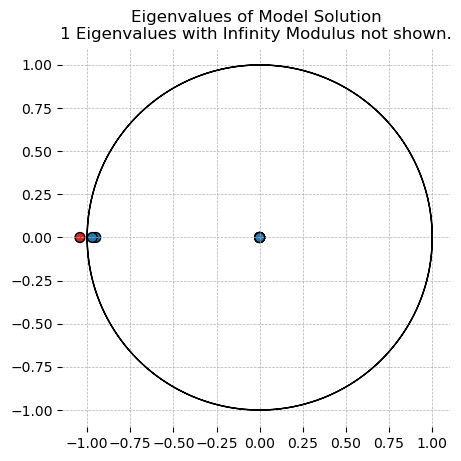

In [45]:
gp.plot_eigenvalues(model);

## Impulse Response Functions

Nor in making and plotting IRFs

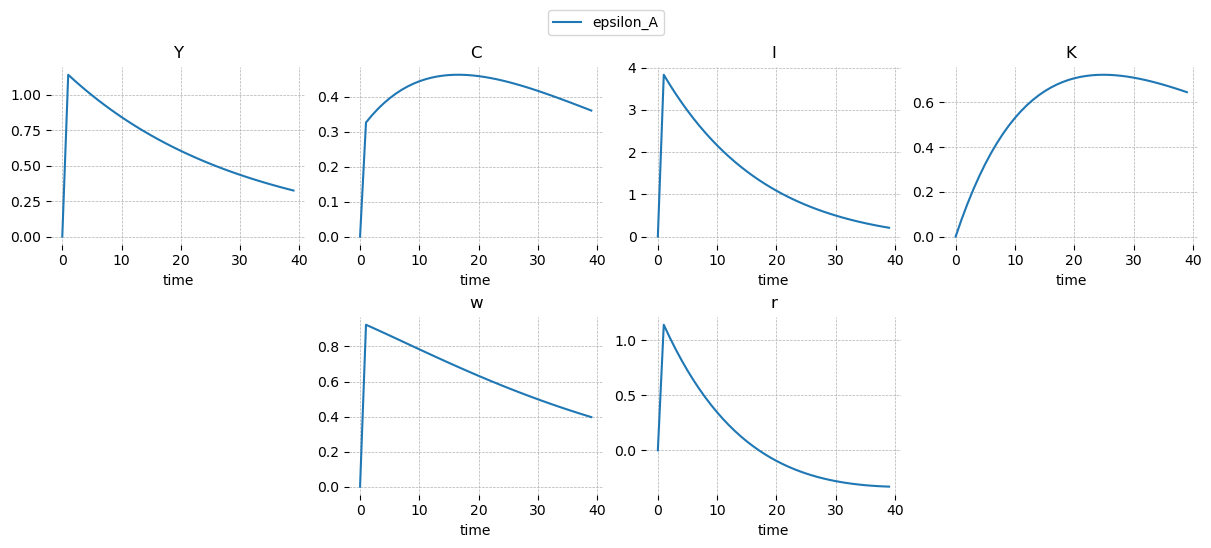

In [46]:
irf = ge.impulse_response_function(model, T=T, R=R, shock_size={"epsilon_A": 1.0})
gp.plot_irf(
    irf,
    vars_to_plot=["Y", "C", "I", "K", "w", "r"],
    n_cols=4,
    figsize=(12, 5),
    legend=True,
);

## Conversion to Dynare

When a `steady_state` block is included in your GCN file, a `steady_state_model` block will automatically be generated for use in Dynare. 

For readability, intermediate variables are generated using `sympy.cse` (for "common sub-expressions"). Skipping this results in extremely unreadable Dynare code. 

In [47]:
print(ge.dynare_convert.make_mod_file(model))

var A, C, I, K, L, Y, lambda, r, w;

varexo epsilon_A;

parameters alpha, beta, delta, rho_A, sigma_C, sigma_L;

alpha = 0.350;
beta = 0.990;
delta = 0.020;
rho_A = 0.950;
sigma_C = 1.500;
sigma_L = 2.000;


model;

-C - I + K(-1) * r + L * w;
I - K + K(-1) * (1 - delta);
-lambda + C ^ (-sigma_C);
-L ^ sigma_L + lambda * w;
beta * (lambda(+1) * r(+1) - lambda(+1) * (delta - 1)) - lambda;
A * K(-1) ^ alpha * L ^ (1 - alpha) - Y;
alpha * A * K(-1) ^ (alpha - 1) * L ^ (1 - alpha) - r;
A * K(-1) ^ alpha * L ^ (-alpha) * (1 - alpha) - w;
rho_A * log(A(-1)) + epsilon_A - log(A);

end;

steady_state_model;
x0 = 1 - alpha;
x1 = 1 / beta;
x2 = delta + x1 - 1;
x3 = alpha / x2;
x4 = x3 ^ (alpha / x0);
x5 = x0 * x4;
x6 = 1 / sigma_C;
x7 = 1 / (sigma_C + sigma_L);
x8 = (x2 / (-alpha * delta + delta + x1 - 1)) ^ (sigma_C * x7) * (x4 ^ sigma_L * x5) ^ x7;
x9 = x8 ^ (-sigma_L * x6) * (x0 ^ (-sigma_L) * x5 ^ (sigma_L + 1)) ^ x6;
x10 = x3 * x8;


A = 1.00000000000000;
C = x9;
I = delta * x10;
K = x10;
L

# Priors

With gEconpy, you can directly declare priors over parameters and shocks using a natural `~` notation. `RBC.gcn` also includes such priors.

gEconpy uses [Preliz](https://preliz.readthedocs.io/en/latest/) to declare and work with priors. Therefore, all distributions and their arguments must match those used by preliz. Most univariate distributions are permitted.

In addition, you *are* allowed to wrap distribtuions in preliz transformation functions, including `Truncated`, `Censored`, and `maxent`. These allow for defining very expressive priors, as follows:

1. Prior declaration

Priors are declared directly in the GCN file using the following notation:

```
sigma_C ~ Normal(mu=1.5, sd=0.1) = 1.5;
```

This parameters is drawn from a [normal distribution](https://preliz.readthedocs.io/en/latest/distributions/gallery/normal.html), which preliz parameterizes using `mu` and `sigma`. For a full list of supported distributions, see the [Preliz distributions gallery](https://preliz.readthedocs.io/en/latest/gallery_content.html). The `=` sign after the distribution declares the initial value of the distribution. This is the default value that will be used when calling `steady_state`, `linearize_model`, `solve_model`, and so on.


Often, we will want to define a lower or upper boundary on a prior. The easiest way to do this is to choose a distribution that has support over the domain of the parameter. For example, autoregressive parameters can be given `Beta` priors:

```
rho_A ~ Beta(alpha=3, beta=1) = 0.95
```

Alternatively, we can use the `Truncated` wrapper to truncate the support of an arbitrary distribution. Perhaps we want a Gamma distribution on $\sigma_C$ (the Arrow-Pratt risk aversion), but we don't want it to go below 1.01 (we're ruling out the log case for numerical stability reasons). This can be accomplished as follows:

```
sigma_C ~ Truncated(Gamma(mu=1.5, sigma=0.5), lower=1.01, upper=None) = 1.5;
```

The prior implied by this configuration is plotted below:

<Axes: >

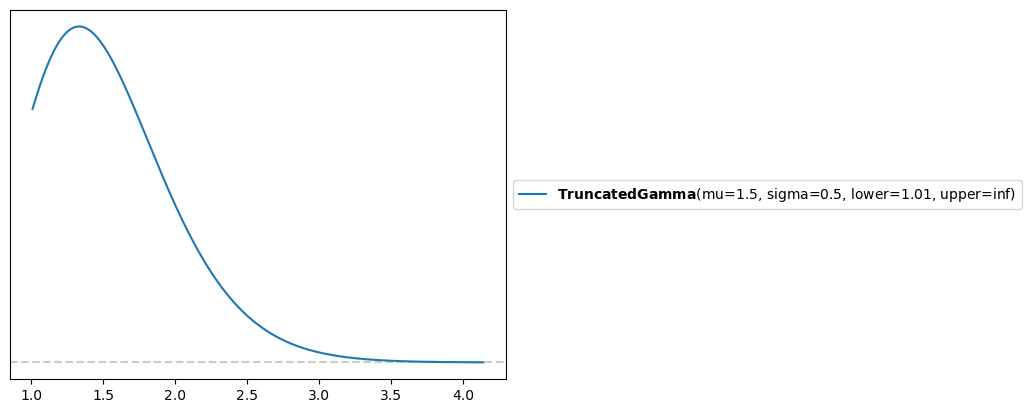

In [48]:
pz.Truncated(pz.Gamma(mu=1.5, sigma=0.5), lower=1.01, upper=None).plot_pdf()

When working with many distributions, it is difficult to map you beliefs about plausable parameter values to hyperparameters for the prior. For example, suppose I do some research and find that values for the Arrow-Pratt risk aversion range between 3 and 8. What prior should be used?

In this case, `pz.maxent` can help. This function finds a distribution from a requested family such that 95% of the probability mass lies between two points. For example, we can find the Inverse Gamma distribution with 95% of the mass between 3 and 8. This turns out to be `InverseGamma(alpha=16, beta=80.1)`.

You can directly use `maxent` inside of your GCN files. For example:

```
sigma_C ~ maxent(InverseGamma(), lower=3, upper=8) = 3.5
```

This makes it easier to share your model with other researchers. If we had written `alpha=16, beta=80.1`, I would be extremely confused. But seeing `maxent(... lower=3, upper=8)`, it is immediately obvious what your prior beliefs about this parameter are.

(InverseGamma(alpha=11.7, beta=59.9), <Axes: >)

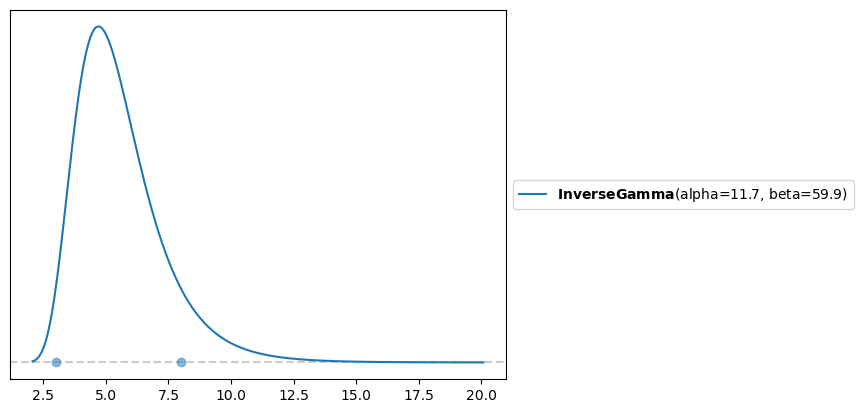

In [49]:
pz.maxent(pz.InverseGamma(), lower=3, upper=8)

In [50]:
file_path = ge.data.get_example_gcn("RBC")
model = ge.model_from_gcn(file_path, verbose=True)

Model Building Complete.
Found:
	9 equations
	9 variables
		The following variables were eliminated at user request:
			TC_t, U_t
		The following "variables" were defined as constants and have been substituted away:
			mc_t
	1 stochastic shock
		 0 / 1 has a defined prior.
	6 parameters
		 6 / 6 parameters has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.



Initial values are whatever is given after the `=`, as explained above.

In [51]:
model.parameters()

{'alpha': np.float64(0.35),
 'beta': np.float64(0.99),
 'delta': np.float64(0.02),
 'rho_A': np.float64(0.95),
 'sigma_C': np.float64(1.5),
 'sigma_L': np.float64(2.0)}

Priors are stored in `model.param_priors` for parameters, and `model.shock_priors` for shocks. In this case, we didn't give any shock priors, so that's an empty dictionary.

In [52]:
model.param_priors

{'beta': Beta(alpha=181, beta=3.55),
 'delta': Beta(alpha=11.5, beta=410),
 'sigma_C': Gamma(alpha=6.66, beta=1.43),
 'sigma_L': Gamma(alpha=6.62, beta=1.42),
 'alpha': Beta(alpha=21.8, beta=41.6),
 'rho_A': Beta(alpha=18.2, beta=2.22)}

In [53]:
model.shock_priors

{}

You can look at the priors set in the GCN file using `gp.plot_priors`. The inital value is marked with a veritcal line.

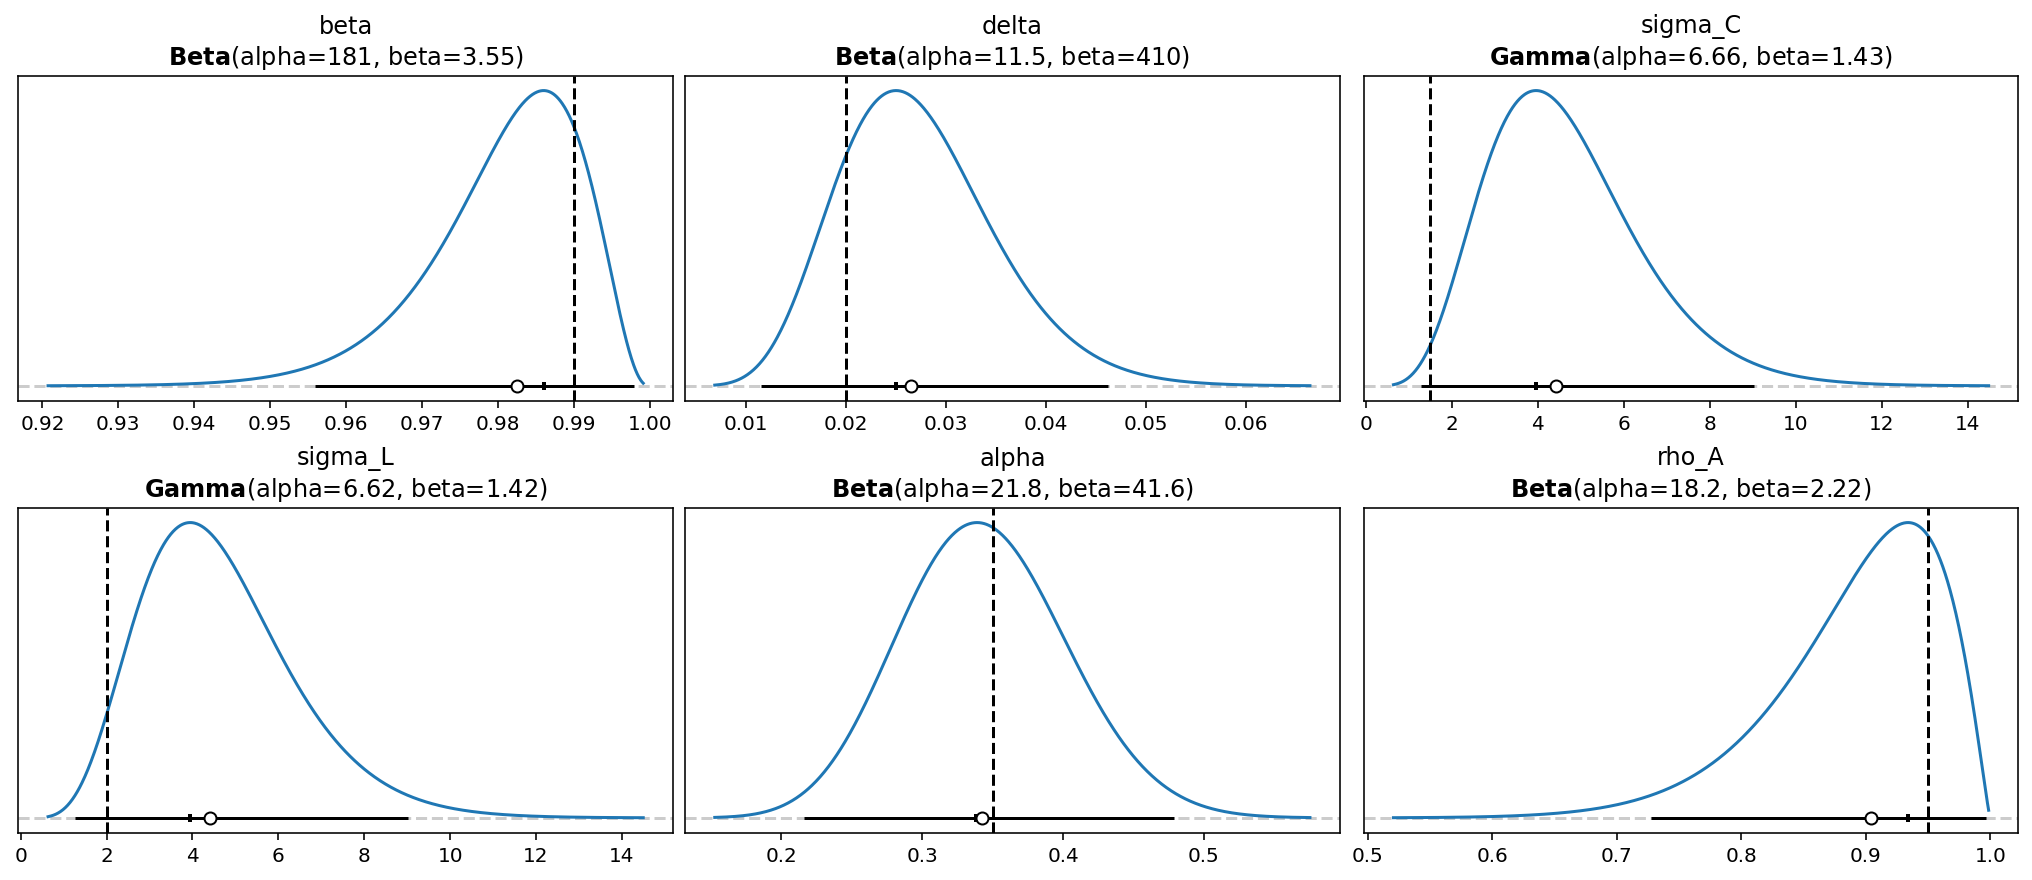

In [54]:
gp.plot_priors(model, n_cols=3, figsize=(14, 6));

In [55]:
ss_res = model.steady_state()
ge.print_steady_state(ss_res)

A_ss               1.000
C_ss               2.358
I_ss               0.715
K_ss              35.732
L_ss               0.820
Y_ss               3.073
lambda_ss          0.276
r_ss               0.030
w_ss               2.436


In [56]:
T, R = model.solve_model(steady_state=ss_res)

Solution found, sum of squared residuals: 0.000000000
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


## Statespace Models

Currently, support for using priors in a `Model` is limited. They are mostly used via the `DSGEStateSpace` class. This can be created using `ge.statespace_from_gcn`

In [57]:
ss_mod = ge.statespace_from_gcn(file_path)

Model Building Complete.
Found:
	9 equations
	9 variables
		The following variables were eliminated at user request:
			TC_t, U_t
		The following "variables" were defined as constants and have been substituted away:
			mc_t
	1 stochastic shock
		 0 / 1 has a defined prior.
	6 parameters
		 6 / 6 parameters has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.

Statespace model construction complete, but call the .configure method to finalize.


In [58]:
type(ss_mod)

gEconpy.model.statespace.DSGEStateSpace

A `DSGEStateSpace` is a bridge between your symbolic DSGE model and a PyMC model. To use it, first call the `.configure` method to set up some options. For more details on all the different options, see the {ref}`introduction to estimation notebook<estimation/estimation_example>` 

In [59]:
ss_mod.configure(
    observed_states=["Y"],
    measurement_error=None,
    solver="scan_cycle_reduction",
    max_iter=20,
    mode="JAX",
)

                  Model Requirements                  
                                                      
  Variable          Shape   Constraints   Dimensions  
 ──────────────────────────────────────────────────── 
  alpha             ()                          None  
  beta              ()                          None  
  delta             ()                          None  
  rho_A             ()                          None  
  sigma_C           ()                          None  
  sigma_L           ()                          None  
  sigma_epsilon_A   ()      Positive            None  
                                                      
 These parameters should be assigned priors inside a  
         PyMC model block before calling the          
            build_statespace_graph method.            

Priors can then be loaded into a PyMC model using `ss_mod.to_pymc()`. Since we didn't specify a prior for `sigma_epsilon_A`, we need to do that ourselves.

In [60]:
import pymc as pm

with pm.Model(coords=ss_mod.coords) as pm_model:
    ss_mod.to_pymc()
    sigma_epsilon_A = pm.Gamma("sigma_epsilon_A", alpha=2, beta=10)

To generate data, use `ge.data_from_prior`

In [61]:
true_params, data, prior = ge.data_from_prior(statepace_mod=ss_mod, pymc_model=pm_model, random_seed=rng)

/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc_extras/statespace/utils/data_tools.py:175: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)
Sampling: [alpha, beta, delta, obs, rho_A, sigma_C, sigma_L, sigma_epsilon_A]
Sampling: [prior_combined]


Output()

For each simulation, the `prior.prior` group saves the steady state error in a variable called `ss_resid`. Using that, we can check if any parameters cause us problems.

The maximum of this parameter is `1e-29`, so all prior draws resulted in a valid steady-state solution.

In [62]:
prior.prior.ss_resid.max().item()

1.954404181097972e-29

We can also check the solver errors. These are stored in two parts, `stochastic_norm` and `deterministic_norm`. Both sould be close to zero for valid model solutions. In this case, they each have a maximum of `1e-15`, so no prior draws were associated with failures in computing the policy function.

In [63]:
prior.prior.stochastic_norm.max().item(), prior.prior.deterministic_norm.max().item()

(2.4281281553682748e-15, 2.4129486322449997e-15)

One final diagnostic is the number of steps required for the cyclic reduciton algorithm to converge. This algorithm is used to compute the QZ decomposition used in solving the policy function. When it needs a lot of steps, it *might* indicate potentially unstable parameters.

In the `.configure` call, we set the maximum number of steps to 20. Among all prior draws, only a maximum of 12 was used.

In [64]:
prior.prior.n_cycle_steps.max().item()

13

### Plot Simulated Trajectories

Finally, we can plot some simulated trajectories from the prior. This is equivalent to `gp.plot_simulation`, but now prior uncertainty about the true parameter values is being taken into account.

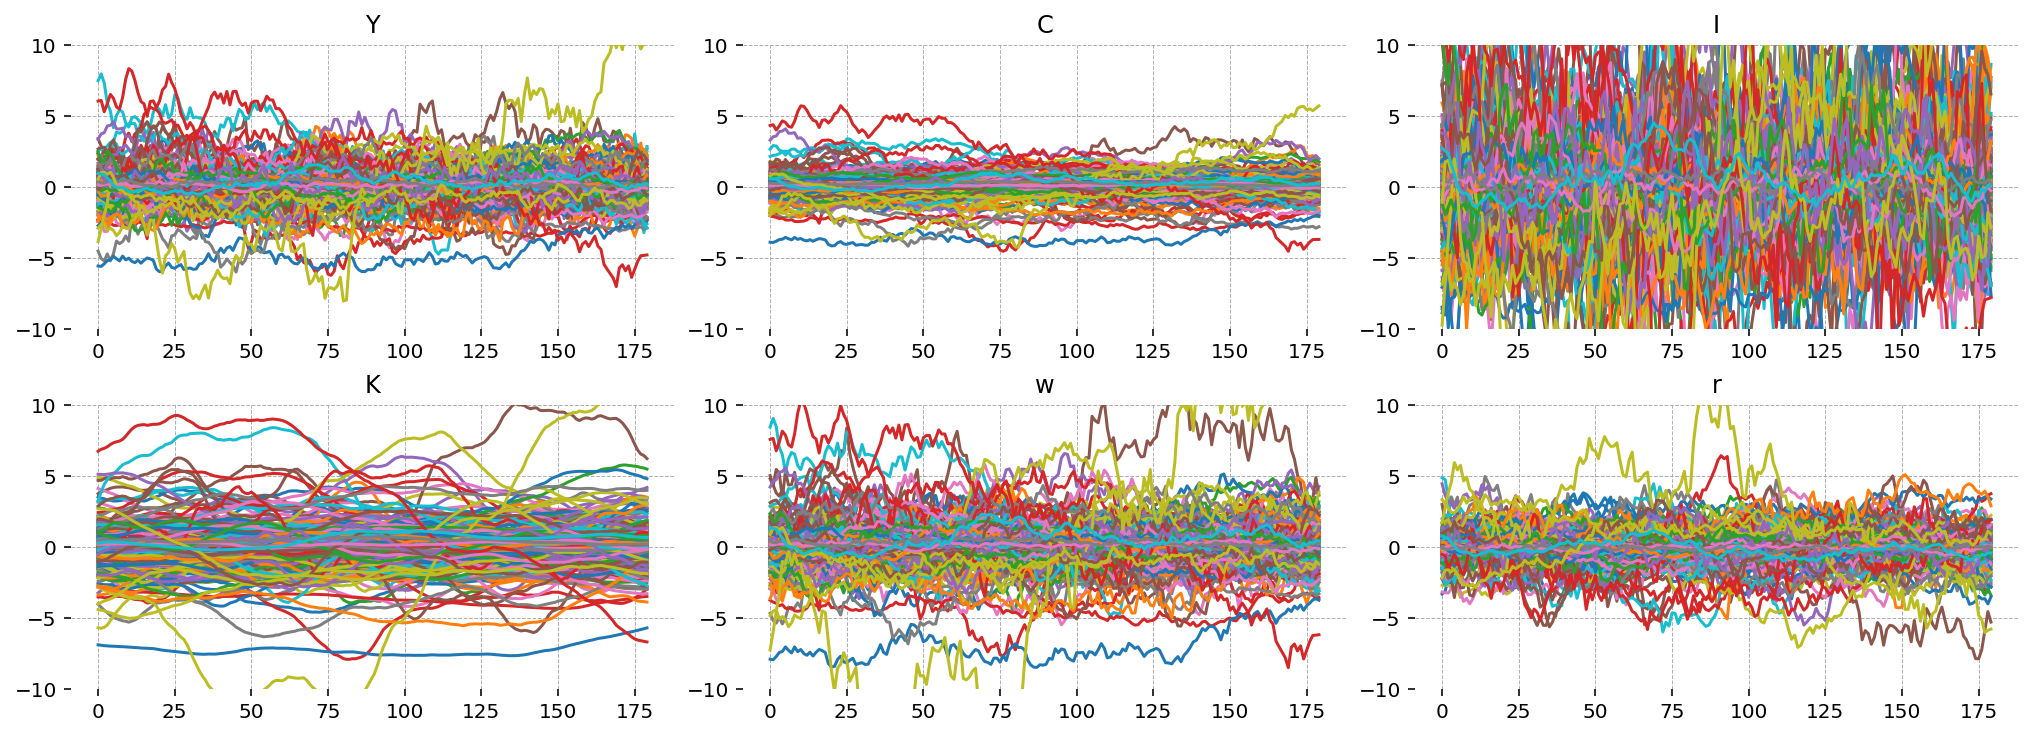

In [65]:
import matplotlib.pyplot as plt

gp.set_matplotlib_style()

fig = plt.figure(figsize=(14, 5), dpi=144)

gs, locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=6, figure=fig)
for loc, var in zip(locs, ["Y", "C", "I", "K", "w", "r"], strict=False):
    axis = fig.add_subplot(gs[loc])
    axis.plot(
        np.arange(data.shape[0]),
        prior.unconditional_prior.prior_latent.sel(chain=0, state=var).values.T,
    )
    axis.set(title=var, ylim=(-10, 10))

plt.show()

# Authors

- Authored by Jesse Grabowski in March 2025

# Watermark

In [66]:
%load_ext watermark
%watermark -n -u -v -iv -w -p gEconpy

Last updated: Sat, 21 Feb 2026

Python implementation: CPython
Python version       : 3.12.12
IPython version      : 9.10.0

gEconpy: 2.0.4.dev3+gda7716c88.d20260206

gEconpy   : 2.0.4.dev3+gda7716c88.d20260206
matplotlib: 3.10.8
numpy     : 2.3.5
pandas    : 3.0.0
preliz    : 0.23.0
pymc      : 5.27.1
xarray    : 2026.1.0

Watermark: 2.6.0

